In [ ]:
!pip install --quiet -U langgraph langchain-community langchain-openai tavily-python python-pptx-interface

In [ ]:
import getpass
import os

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")

# Optional, add tracing in LangSmith.
# This will help you visualize and debug the control flow
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent pptx"

Please provide your OPENAI_API_KEY··········
Please provide your LANGCHAIN_API_KEY··········


In [ ]:
import pandas as pd

df = pd.DataFrame()
df['year'] = [2002, 2003, 2004, 2005, 2006]
df['value'] = [1213.2, 2341.2, 2741.2, 2003.2, 2453.2]
df[:3].to_excel('data.xlsx', index=False)

print(df[:3].to_markdown())

|    |   year |   value |
|---:|-------:|--------:|
|  0 |   2002 |  1213.2 |
|  1 |   2003 |  2341.2 |
|  2 |   2004 |  2741.2 |


In [ ]:
from typing import Annotated, List, TypedDict
from langchain_core.tools import tool


@tool
def read_table(
    file_name: Annotated[str, "The table file path."],
    ) -> Annotated[str, "Table as Markdown."]:
    """Read the xlsx file with the table and return it to Markdown."""

    df = pd.read_excel(file_name)
    return df.to_markdown()


@tool
def read_document(
    file_name: Annotated[str, "The document file path."],
) -> Annotated[str, "Data from file."]:
    """Read the specified txt document."""

    with open(file_name, "r") as file:
        data = file.read()
    return data

In [ ]:
import os
from pptx_tools.creator import PPTXCreator
from pptx_tools.position import PPTXPosition


@tool
def insert_table_to_presentation(
    table_data: Annotated[list[list], "Outer iter -> rows, inner iter -> cols."],
) -> Annotated[str, "Result."]:
    """Insert a table shape with given table_data to presentation.
    For example, the table:
    |    | column_1   | column_2   |
    |---:|:-----------|:-----------|
    |  0 | value_1    | value_2    |
    |  1 | value_3    | value_4    |
    should be given in this format:
    table_data=[['column_1','column_2'], ['value_1','value_2'], ['value_3','value_4']]"""

    pp = PPTXCreator()
    slide_01 = pp.add_slide("")
    pp.add_table(slide_01, table_data, PPTXPosition(0.02, 0.14))
    pp.save("table_style_example_01.pptx", overwrite=True)

    return 'Success'

In [ ]:
from typing import List, Optional

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph, START


def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""

    system_prompt += "Work autonomously according to your specialty, using the tools available to you."
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}


def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

In [ ]:
import functools
import operator

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI



class TeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str


llm = ChatOpenAI(model="gpt-4o-mini")

file_reader_agent = create_agent(
    llm,
    [read_table, read_document],
    "You are a file_reader assistant who can read excel files with tables and txtx files.",
)
file_read_node = functools.partial(agent_node, agent=file_reader_agent, name="FileReader")

presentation_editor_agent = create_agent(
    llm,
    [insert_table_to_presentation],
    "You are an assistant who can edit presentations and add tables to them",
)
presentation_edit_node = functools.partial(agent_node, agent=presentation_editor_agent, name="PresentationEditor")

supervisor_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: FileReader, PresentationEditor. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["FileReader", "PresentationEditor"],
)

In [ ]:
research_graph = StateGraph(TeamState)
research_graph.add_node("FileReader", file_read_node)
research_graph.add_node("PresentationEditor", presentation_edit_node)
research_graph.add_node("supervisor", supervisor_agent)

# Define the control flow
research_graph.add_edge("FileReader", "supervisor")
research_graph.add_edge("PresentationEditor", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"FileReader": "FileReader", "PresentationEditor": "PresentationEditor", "FINISH": END},
)


research_graph.add_edge(START, "supervisor")
chain = research_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results


research_chain = enter_chain | chain

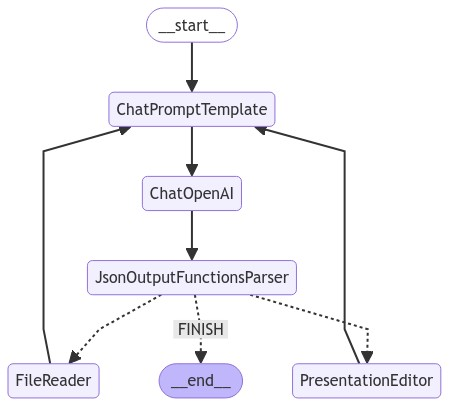

In [ ]:
from IPython.display import Image, display

display(Image(chain.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["FileReader", "PresentationEditor"],
)

In [ ]:
supervisor_node

ChatPromptTemplate(input_variables=['messages'], input_types={'messages': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, partial_variables={'options': "['FINISH', 'FileReader', 'PresentationEditor']", 'team_members': 'FileReader, PresentationEditor'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['team_members'], template='You are a supervisor tasked with managing a conversation between the following workers: {team_members}. Given the following user request, respond with the worker to act next. Each worker will perform a task and respond with their results and status. When finished, respond with FINISH.')), MessagesPlaceholder(variable_name='messages'), SystemMessagePromptTemplate(prompt=PromptTemplate(input_variable

In [ ]:
from langchain_core.messages import BaseMessage
from langchain_openai.chat_models import ChatOpenAI

In [ ]:
# Top-level graph state
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str


def get_last_message(state: State) -> str:
    return state["messages"][-1].content


def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}


# Define the graph.
super_graph = StateGraph(State)
# First add the nodes, which will do the work
super_graph.add_node("FileReader", file_read_node)
super_graph.add_node("PresentationEditor",presentation_edit_node)
super_graph.add_node("supervisor", supervisor_node)

# Define the graph connections, which controls how the logic
# propagates through the program
super_graph.add_edge("FileReader", "supervisor")
super_graph.add_edge("PresentationEditor", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "FileReader": "FileReader",
        "PresentationEditor": "PresentationEditor",
        "FINISH": END,
    },
)
super_graph.add_edge(START, "supervisor")
super_graph = super_graph.compile()

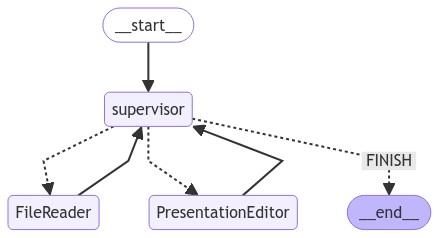

In [ ]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [ ]:
for s in super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Add table from data.xlsx to presentation"
            )
        ],
    },
    {"recursion_limit": 10},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'FileReader'}}
---
{'FileReader': {'messages': [HumanMessage(content="Here's the table extracted from the `data.xlsx` file:\n\n| Year | Value  |\n|------|--------|\n| 2002 | 1213.2 |\n| 2003 | 2341.2 |\n| 2004 | 2741.2 |\n\nYou can now add this table to your presentation. Let me know if you need further assistance!", name='FileReader')]}}
---
{'supervisor': {'next': 'PresentationEditor'}}
---
{'PresentationEditor': {'messages': [HumanMessage(content='The table has been successfully added to the presentation. If you need any further assistance or modifications, feel free to ask!', name='PresentationEditor')]}}
---
{'supervisor': {'next': 'FINISH'}}
---


In [ ]:
for s in super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Read info from data.txt, create table and add it to presentation"
            )
        ],
    },
    {"recursion_limit": 10},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'FileReader'}}
---
{'FileReader': {'messages': [HumanMessage(content='The data from "data.txt" includes population information for the years 2001 to 2003. Here’s the table based on that information:\n\n| Year | Population |\n|------|------------|\n| 2001 | 30         |\n| 2002 | 60         |\n| 2003 | 100        |\n\nWould you like to do anything else with this table?', name='FileReader')]}}
---
{'supervisor': {'next': 'PresentationEditor'}}
---
{'PresentationEditor': {'messages': [HumanMessage(content='The table with population information for the years 2001 to 2003 has been successfully added to the presentation. If you need any further modifications or additional information, feel free to ask!', name='PresentationEditor')]}}
---
{'supervisor': {'next': 'FINISH'}}
---


In [ ]:
for s in super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Прочитай данные из файла data.txt, создай таблицу и добавь ее в презентацию"
            )
        ],
    },
    {"recursion_limit": 10},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'FileReader'}}
---
{'FileReader': {'messages': [HumanMessage(content='Из файла `data.txt` получены следующие данные:\n\n- В 2001 году население было 30 человек.\n- В 2002 году население было 60 человек.\n- В 2003 году население было 100 человек.\n\nНа основе этих данных можно создать таблицу:\n\n| Год  | Население |\n|------|-----------|\n| 2001 | 30        |\n| 2002 | 60        |\n| 2003 | 100       |\n\nЕсли вам нужно создать презентацию, пожалуйста, подтвердите, и я продолжу.', name='FileReader')]}}
---
{'supervisor': {'next': 'PresentationEditor'}}
---
{'PresentationEditor': {'messages': [HumanMessage(content='Таблица с данными о населении была успешно добавлена в презентацию. Если вам нужно что-то еще, дайте знать!', name='PresentationEditor')]}}
---
{'supervisor': {'next': 'FINISH'}}
---
